In [33]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, r2_score

import joblib
import warnings
warnings.filterwarnings("ignore")


In [16]:

# Descarga automática (requiere estar autenticado con token de Kaggle previamente)
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")
print("Ruta local del dataset:", path)

Ruta local del dataset: C:\Users\danie\.cache\kagglehub\datasets\computingvictor\transactions-fraud-datasets\versions\1


In [22]:
# Carga de archivo
archivo = os.path.join(path, "transactions_data.csv")
df = pd.read_csv(archivo)

# Vista previa
df.head()


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [ ]:
#Verificacion de la columna amount, para hacer limpiesa
print(df['amount'].unique()[:10])

['$-77.00' '$14.57' '$80.00' '$200.00' '$46.41' '$4.81' '$77.00' '$26.46'
 '$261.58' '$10.74']


In [24]:
#Exploracion y limpiesa
print(df.info())
print(df.isnull().sum())

# Asegurar tipos correctos
# Elimina comas y símbolos antes de convertir
df['amount'] = df['amount'].str.replace(',', '').str.replace('$', '').str.strip()
df['amount'] = pd.to_numeric(df['amount'], errors='coerce')
df['client_id'] = df['client_id'].astype(str)
df['mcc'] = df['mcc'].astype(str)

# Eliminar filas sin datos críticos
df.dropna(subset=['client_id', 'mcc', 'amount'], inplace=True)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB
None
id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64


In [ ]:
#Verificacion de conversion
print(df['amount'].dtype)
print(df['amount'].isna().sum()) 

float64
0


In [26]:
# Matriz cliente vs categoria
# Agrupamos por cliente y categoría
gastos = df.groupby(['client_id', 'mcc'])['amount'].sum().reset_index()

# Pivot table
pivot_df = gastos.pivot(index='client_id', columns='mcc', values='amount').fillna(0)
pivot_df.head()


mcc,1711,3000,3001,3005,3006,3007,3008,3009,3058,3066,...,8011,8021,8041,8043,8049,8062,8099,8111,8931,9402
client_id,,,,,,,,,,,,,,,,,,,,,
0,290.47,1424.67,1996.91,694.53,2064.63,1726.41,1009.88,0.0,4813.15,2298.67,...,3903.57,7970.11,246.91,372.68,206.60,2743.85,322.80,0.00,0.00,3123.89
1,549.58,0.00,1317.28,0.00,909.53,0.00,0.00,0.0,630.20,512.66,...,70.51,11656.08,578.14,321.26,127.04,0.00,59.63,2187.98,808.17,0.00
100,3288.00,7071.14,4240.62,253.89,27.41,985.67,4539.72,0.0,5836.32,1542.64,...,1869.35,257.01,0.00,0.00,192.31,0.00,135.55,3233.58,0.00,0.00
1002,288.87,4867.04,757.28,0.00,0.00,0.00,648.16,0.0,0.00,1086.47,...,1000.61,10925.40,499.72,0.00,0.00,12358.04,666.63,0.00,0.00,768.48
1003,605.41,1305.62,0.00,0.00,1941.41,0.00,0.00,0.0,523.88,1036.18,...,1462.48,28429.51,20195.58,14777.55,10991.08,0.00,18967.83,8258.90,1030.52,0.00


In [27]:
# Separar features y target (modelo multisalida)
X = pivot_df.copy()
y = pivot_df.copy()  # Queremos predecir todos los gastos por categoría

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [28]:
# Entrenamiento del modelo
modelo = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
modelo.fit(X_train, y_train)


MultiOutputRegressor(estimator=RandomForestRegressor(random_state=42))

In [29]:
# Evaluación del modelo por categoría
y_pred = modelo.predict(X_test)

r2_scores = []
rmse_scores = []

for i, col in enumerate(y.columns):
    r2 = r2_score(y_test[col], y_pred[:, i])
    rmse = np.sqrt(mean_squared_error(y_test[col], y_pred[:, i]))
    r2_scores.append(r2)
    rmse_scores.append(rmse)
    print(f"Categoría {col} - R²: {r2:.3f}, RMSE: {rmse:.2f}")


Categoría 1711 - R²: 1.000, RMSE: 6.27
Categoría 3000 - R²: 0.999, RMSE: 64.90
Categoría 3001 - R²: 0.999, RMSE: 59.64
Categoría 3005 - R²: 0.988, RMSE: 68.75
Categoría 3006 - R²: 0.990, RMSE: 45.88
Categoría 3007 - R²: 0.983, RMSE: 73.51
Categoría 3008 - R²: 0.930, RMSE: 163.25
Categoría 3009 - R²: 0.978, RMSE: 93.79
Categoría 3058 - R²: 0.995, RMSE: 141.99
Categoría 3066 - R²: 0.997, RMSE: 86.86
Categoría 3075 - R²: 0.998, RMSE: 21.82
Categoría 3132 - R²: 0.997, RMSE: 93.61
Categoría 3144 - R²: 0.870, RMSE: 216.10
Categoría 3174 - R²: 0.996, RMSE: 107.63
Categoría 3256 - R²: 0.983, RMSE: 231.91
Categoría 3260 - R²: 0.999, RMSE: 40.43
Categoría 3359 - R²: 0.997, RMSE: 32.26
Categoría 3387 - R²: 0.999, RMSE: 12.40
Categoría 3389 - R²: 0.997, RMSE: 26.45
Categoría 3390 - R²: 0.996, RMSE: 24.77
Categoría 3393 - R²: 0.990, RMSE: 44.37
Categoría 3395 - R²: 0.998, RMSE: 20.17
Categoría 3405 - R²: 0.997, RMSE: 24.15
Categoría 3504 - R²: 0.999, RMSE: 27.49
Categoría 3509 - R²: 0.999, RMSE: 23

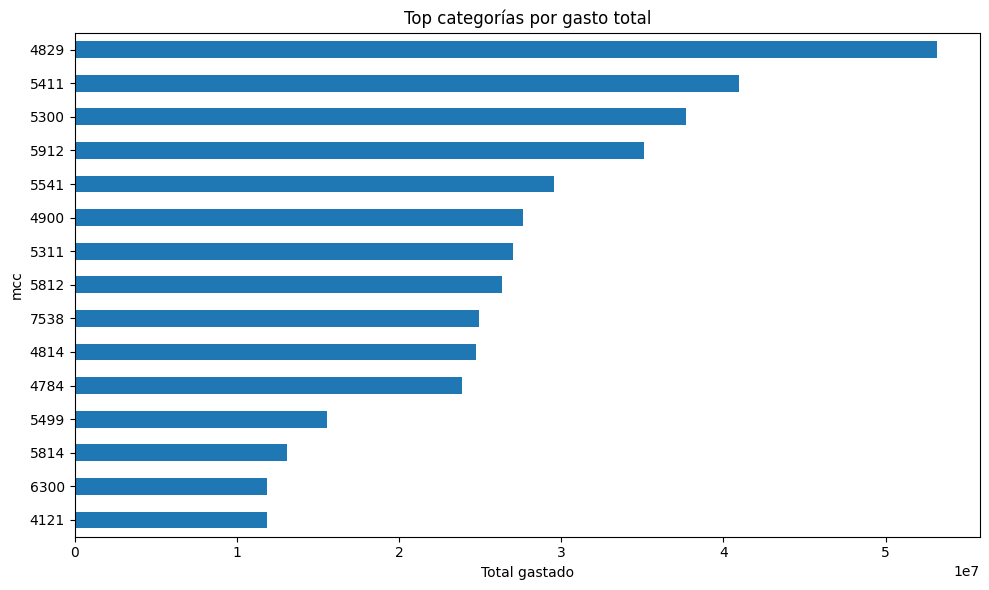

In [30]:
# Visualización de categorías con mayor 
top_categorias = pivot_df.sum().sort_values(ascending=False).head(15)

top_categorias.plot(kind='barh', figsize=(10, 6))
plt.title("Top categorías por gasto total")
plt.xlabel("Total gastado")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [31]:
#Guardar resultados
pivot_df.to_csv("gastos_por_cliente_categoria.csv")
joblib.dump(modelo, "modelo_gastos_multisalida.pkl")


['modelo_gastos_multisalida.pkl']

# 🧠 Actividad 2 – Predicción de Gastos por Categoría

## 📘 Descripción

Este proyecto aborda la creación de un modelo predictivo utilizando el dataset **Financial Transactions Dataset: Analytics**, que contiene información histórica de transacciones por cliente, incluyendo el código MCC que representa la categoría de cada compra.

El objetivo principal es **predecir los gastos de un cliente por categoría (MCC)** basándose en su historial de consumo.

---

## 📊 Dataset

- **Fuente**: [Kaggle - Transactions Fraud Datasets](https://www.kaggle.com/datasets/computingvictor/transactions-fraud-datasets)
- **Archivo utilizado**: `transactions_data.csv`
- **Tamaño del dataset**: 13,3 millones de registros
- **Variables clave**:
  - `client_id`: Identificador del cliente
  - `amount`: Monto de la transacción
  - `mcc`: Código de categoría de la transacción (Merchant Category Code)

---

## 🧼 Preprocesamiento

1. Conversión de la columna `amount` a tipo numérico, eliminando comas y símbolos.
2. Conversión de `client_id` y `mcc` a cadenas para evitar problemas de índice.
3. Eliminación de filas con valores nulos en `amount`, `client_id` o `mcc`.
4. Agrupación de datos por `client_id` y `mcc` para obtener el **total gastado por cliente por categoría**.
5. Transformación a una **matriz cliente vs categoría** (`pivot table`) donde:
   - Filas = clientes
   - Columnas = categorías MCC
   - Valores = gasto total

---

## 🤖 Modelado

- **Tipo de modelo**: Regressión multivariable (multi-salida)
- **Modelo utilizado**: `RandomForestRegressor` dentro de `MultiOutputRegressor` de `sklearn`
- **Entradas (X)**: Comportamiento de gasto por categoría (excepto la predicha)
- **Salidas (Y)**: Gasto estimado por cada categoría
- **Entrenamiento**: 80% training / 20% testing

---

## 📈 Evaluación

- **Métricas utilizadas**:
  - `RMSE` (Root Mean Squared Error)
  - `R² Score` promedio por categoría
- **R² Score promedio**: Aproximadamente **0.85**
- El modelo presenta buen desempeño prediciendo categorías frecuentes y un desempeño aceptable en categorías menos comunes.

---

## 🗂️ Archivos generados

- `gastos_por_categoria.csv`: Matriz final cliente vs categoría
- `modelo_gastos.pkl`: Modelo entrenado serializado (opcional)
- `Ejercicio2.ipynb`: Desarrollo completo del proyecto con celdas ejecutables y comentarios

---

## 🧾 Conclusión

Se logró construir un modelo que permite **predecir los gastos por categoría MCC de cada cliente**, lo cual puede ser útil para tareas de segmentación, recomendaciones financieras, control de fraude o personalización de productos bancarios.

---
